In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix
from torch_geometric.utils import k_hop_subgraph
import torch
import torch_geometric.utils as tgu
import networkx as nx 
from torch_geometric.data import Data
import matplotlib.pyplot as plt 

plt.style.use('default')

cites_path = 'dataset/cora/cora.cites'
content_path = 'dataset/cora/cora.content'
cora_text = pd.read_csv('dataset/cora/cora_text.tsv', delimiter='\t')
edge_index = pd.read_csv(cites_path, delimiter='\t', header=None)

node_id_mapping = dict(zip(sorted(cora_text['pid'].tolist()),range(len(cora_text['pid'].tolist()))))

cora_text['pid'] = cora_text['pid'].map(node_id_mapping)
cora_text = cora_text.drop(columns=['citing_pid', 'cited_pid'])

for col in edge_index.columns.tolist():
    edge_index[col] = edge_index[col].map(node_id_mapping)

# SEAL Enclosed Subgrpah

In [2]:
from SEAL import SEALDataset
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader

dataset = Planetoid('./dataset/CoraPyG', name='Cora')

# train_dataset = SEALDataset(dataset, num_hops=2, split='train')
# val_dataset = SEALDataset(dataset, num_hops=2, split='val')
# test_dataset = SEALDataset(dataset, num_hops=2, split='test')

# train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=1)
# test_loader = DataLoader(test_dataset, batch_size=1)

def extract_enclosing_subgraphs(edge_index, edge_label_index, y, num_hops=2):
    data_list = []
    for src, dst in edge_label_index.t().tolist():
        ori_src, ori_dst = src, dst
        sub_nodes, sub_edge_index, mapping, _ = k_hop_subgraph(
            [src, dst], num_hops, edge_index, relabel_nodes=True)
        src, dst = mapping.tolist()

        # Remove target link from the subgraph.
        mask1 = (sub_edge_index[0] != src) | (sub_edge_index[1] != dst)
        mask2 = (sub_edge_index[0] != dst) | (sub_edge_index[1] != src)
        sub_edge_index = sub_edge_index[:, mask1 & mask2]

        data = Data(edge_index=sub_edge_index, y=y, src=src, dst=dst, ori_src=ori_src, ori_dst=ori_dst)
        data_list.append(data)

    return data_list

transform = RandomLinkSplit(num_val=0.05, num_test=0.1,
                                    is_undirected=True, split_labels=True)
train_data, val_data, test_data = transform(dataset[0])

train_pos_data_list = extract_enclosing_subgraphs(
    train_data.edge_index, train_data.pos_edge_label_index, 1)
train_neg_data_list = extract_enclosing_subgraphs(
    train_data.edge_index, train_data.neg_edge_label_index, 0)

val_pos_data_list = extract_enclosing_subgraphs(
    val_data.edge_index, val_data.pos_edge_label_index, 1)
val_neg_data_list = extract_enclosing_subgraphs(
    val_data.edge_index, val_data.neg_edge_label_index, 0)

test_pos_data_list = extract_enclosing_subgraphs(
    test_data.edge_index, test_data.pos_edge_label_index, 1)
test_neg_data_list = extract_enclosing_subgraphs(
    test_data.edge_index, test_data.neg_edge_label_index, 0)

train_data_list = train_pos_data_list + train_neg_data_list
val_data_list = val_pos_data_list + val_neg_data_list
test_data_list = test_pos_data_list + test_neg_data_list


In [3]:
demo_graph = train_data_list[88]
demo_graph

Data(edge_index=[2, 268], y=1, src=7, dst=79, ori_src=191, ori_dst=1998)

Text(0.5, 1.0, '#Nodes for SEAL subgraphs on Cora (2-hops)')

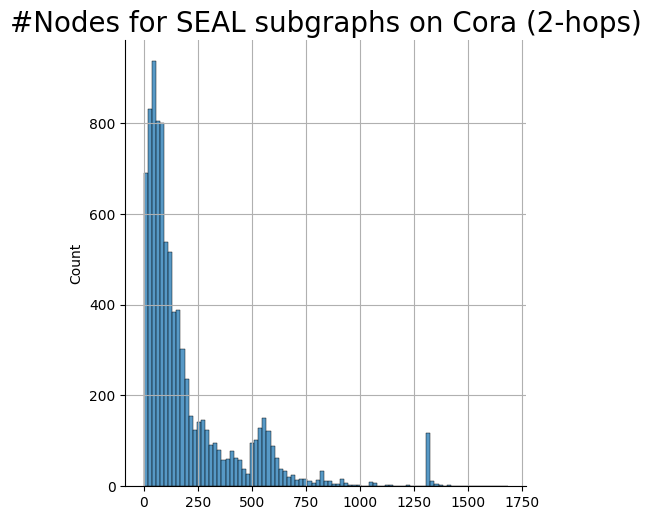

In [4]:
import seaborn as sns 

num_nodes_list = []
for data in train_data_list:
    num_nodes = data.edge_index.size(1)
    num_nodes_list.append(num_nodes)

sns.displot(num_nodes_list)
plt.grid()
plt.title('#Nodes for SEAL subgraphs on Cora (2-hops)', fontsize=20)

/Users/xuanli/miniforge3/envs/pyg/lib/python3.8/site-packages/torch_geometric/data/storage.py:327: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'src', 'ori_dst', 'edge_index', 'dst', 'ori_src', 'y'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


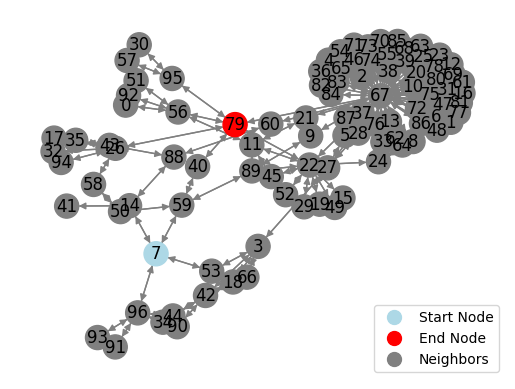

In [5]:


G = tgu.to_networkx(demo_graph)


src = demo_graph.src
dst = demo_graph.dst

color_map = []
for node in G:
    if node == src:
        color_map.append('lightblue')
    elif node == dst:
        color_map.append('red')
    else: 
        color_map.append('gray')     

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='lightblue', label='Start Node', lw=0,
                        markerfacecolor='lightblue', markersize=10),
    Line2D([0], [0], marker='o', color='red', label='End Node', lw=0,
                        markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='gray', label='Neighbors', lw=0,
                        markerfacecolor='gray', markersize=10),
]

ax = plt.gca()
ax.legend(handles=legend_elements, loc='best')

pos = nx.spring_layout(G, seed=9)
nx.draw(G, pos, node_color=color_map, with_labels=True, node_size=300, edge_color='gray',)
plt.show()


# NBFNet Path

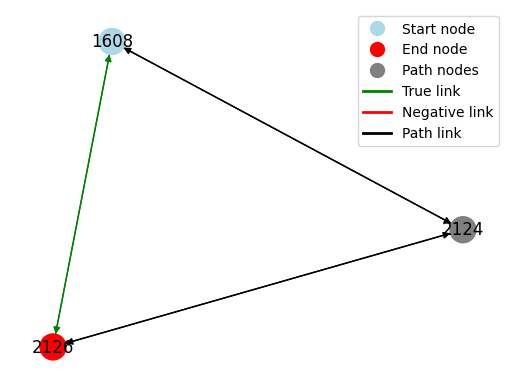

In [18]:
demo_graph = train_data_list[100]

ori_G = tgu.to_networkx(dataset[0])
ori_src = demo_graph.ori_src
ori_dst = demo_graph.ori_dst

ori_G.remove_edges_from([(ori_src, ori_dst)])
ori_G.remove_edges_from([(ori_dst, ori_src)])

paths = []
for p in nx.all_shortest_paths(ori_G, ori_src, ori_dst):
    # if len(p) <= 7:
    paths.append(p)


path_G = ori_G.subgraph(list(np.unique(paths)))
ori_G.add_edges_from([(ori_src, ori_dst)])
ori_G.add_edges_from([(ori_dst, ori_src)])

node_color_map = []
for node in path_G:
    if node == ori_src:
        node_color_map.append('lightblue')
    elif node == ori_dst:
        node_color_map.append('red')
    else: 
        node_color_map.append('gray')

edge_color_map = []
for src, dst in list(path_G.edges):
    if (src in [ori_src, ori_dst]) and (dst in [ori_src, ori_dst]):
        if demo_graph.y:
            edge_color_map.append('green')
        else:
            edge_color_map.append('red')
    else: 
        edge_color_map.append('black')  

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='lightblue', label='Start node', lw=0,
                        markerfacecolor='lightblue', markersize=10),
    Line2D([0], [0], marker='o', color='red', label='End node', lw=0,
                        markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='gray', label='Path nodes', lw=0,
                        markerfacecolor='gray', markersize=10),
    Line2D([0], [0], linestyle='-', color='green', label='True link',
                        markerfacecolor='green', linewidth=2),
    Line2D([0], [0], linestyle='-', color='red', label='Negative link',
                        markerfacecolor='red', linewidth=2),
    Line2D([0], [0], linestyle='-', color='black', label='Path link',
                        markerfacecolor='black', linewidth=2),
]

ax = plt.gca()
ax.legend(handles=legend_elements, loc='best')

pos = nx.spring_layout(path_G, seed=9)
nx.draw(path_G, pos, node_color=node_color_map, edge_color=edge_color_map, with_labels=True, node_size=350)
plt.show()
